# Phase change in signal propagation

In [2]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import filter
from src import metrics
from src import operations
from src import graph_utils
from src import jordanzero_destroy

from src import plot_surf

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

# import warnings
# # Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)s

In [3]:
root_path = "../"

In [4]:
def directed_wn_generator(nb_repeat, U, seed=99):
    np.random.seed(seed)
    N = U.shape[0]
    # Generating White Noise equivalent in directed graph
    covariance_dir = (U @ operations.hermitian(U)).real
    tmpV, tmpU = np.linalg.eig(covariance_dir)
    assert np.all(tmpV > 0) # check covariance dir is semi-positive definite so that z = U @ sqrt(V) @ x is real

    if nb_repeat == 1:
        z = tmpU @ np.sqrt(np.diag(tmpV)) @ np.random.normal(0, 1, N)
        return z
    
    ret_z = []
    for _ in range(nb_repeat):
        z = tmpU @ np.sqrt(np.diag(tmpV)) @ np.random.normal(0, 1, N)
        ret_z.append(z)
    ret_z = np.array(ret_z)
    return ret_z

## Description



GOAL: 

## Table of Contents
- [Behaviour of phase propopagation of signal (modelled by shifting)](#behaviour-phase)
    - Simulated example - Rosace
    - Simulated example - Modular blocks

## Behaviour of phase propopagation of signal (simulated by shifting)

### Simulated example - Rosace

/Users/mikichan/Desktop/mywork/brain_phase_response/notebooks/../src/jordanzero_destroy.py:64: RuntimeWarning: invalid value encountered in arccos
  D = np.nan_to_num(np.arccos(np.abs(vr.T@vr)))


Method chosen is: eig


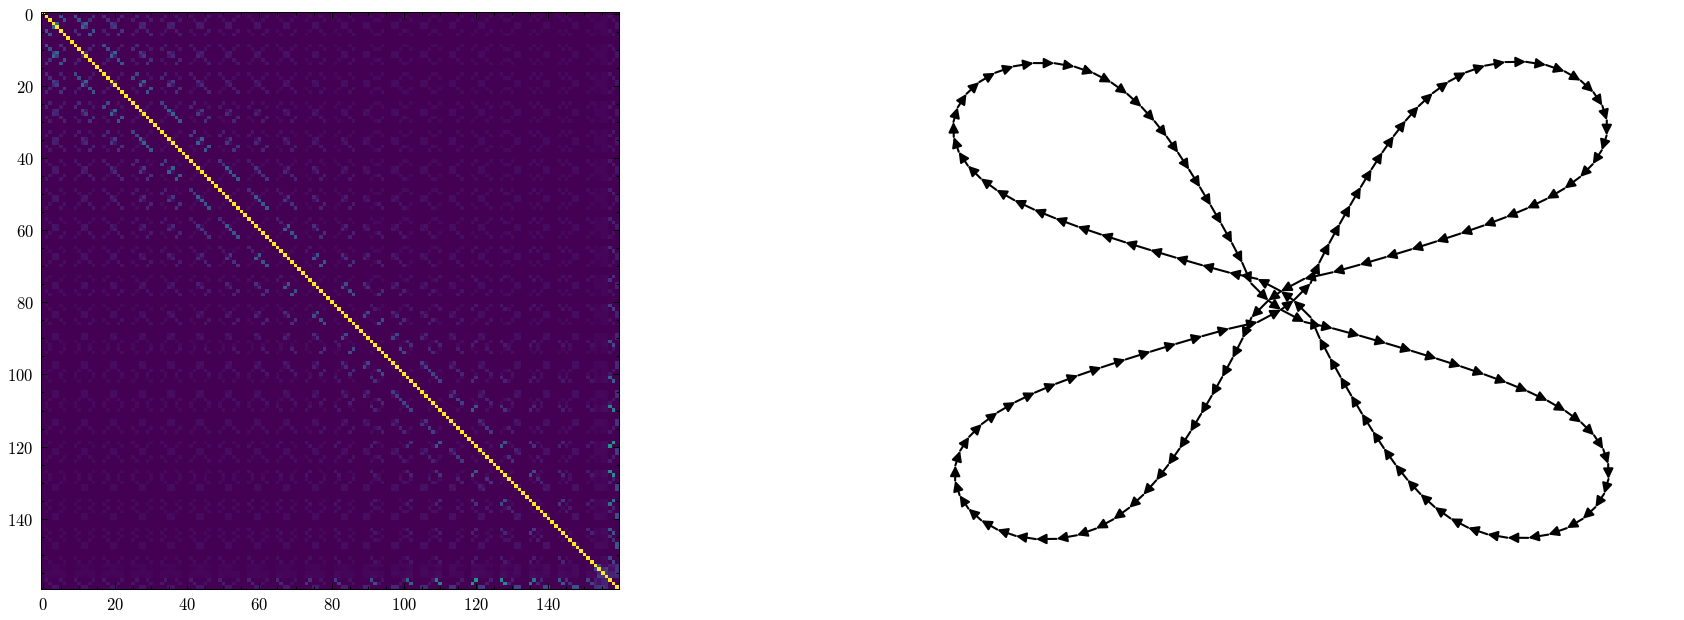

In [5]:
Nr = 40
cycle = graph_utils.make_graph(Nr, graph_type="cycle")
Nc = 4
A = np.zeros((Nc * Nr, Nc * Nr))
for k in range(Nc):
    tmp = deepcopy(cycle)
    if k in np.arange(Nc):
        tmp[-1][0] = 0
    A[k * Nr : (k + 1) * Nr, k * Nr : (k + 1) * Nr] = tmp
    if k + 1 == Nc:
        A[0, k * Nr] = 1
    else:
        A[(k + 1) * Nr, k * Nr] = 1

# Apply perturbation to make graph digonalizble -> invertible
newA = jordanzero_destroy.destroy_jordan_blocks(A, prefer_nodes=[0 + Nr * k for k in range(Nc)])

N = newA.shape[0]

A = 1/np.abs(np.linalg.eigvals(newA)).max() * newA
L, U, V, Uinv, S, J, Sinv = graph_utils.prep_transform(A, gso="laplacian")

G, pos = graph_utils.vis_graph(newA, U, -1, figsize=(15, 5))

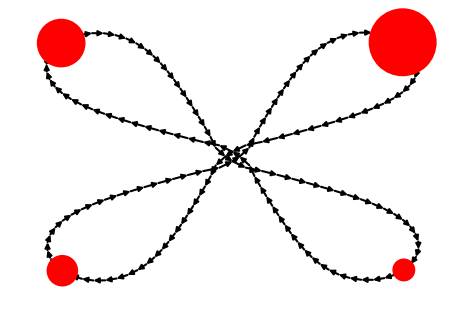

In [6]:
cycle_signal = np.zeros(N)
cycle_signal[20] = 10
cycle_signal[60] = 5
cycle_signal[100] = 2
cycle_signal[140] = 1
graph_utils.plot_graph(G, cycle_signal, pos, arrowsize=5)

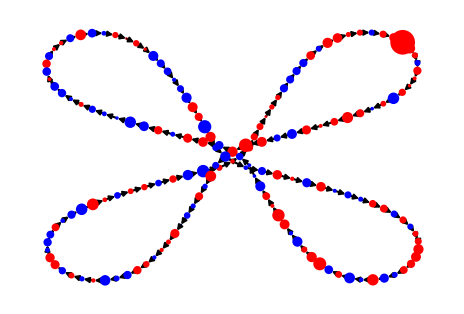

In [7]:
T = 200
period = 1
timecourses = np.zeros((N, T))
excite_amp = 10

wn_sequences = directed_wn_generator(T, U)
# initial condition
timecourses[:, 0] = wn_sequences[0]
cycle_signal1 = np.zeros(N) ; cycle_signal1[20] = excite_amp
cycle_signal2 = np.zeros(N) ; cycle_signal2[60] = excite_amp
cycle_signal3 = np.zeros(N) ; cycle_signal3[100] = excite_amp
cycle_signal4 = np.zeros(N) ; cycle_signal4[140] = excite_amp

cycle_signals = [cycle_signal1, cycle_signal2, cycle_signal3, cycle_signal4]
gamma = 0.7

# Generate timecourses
for t in range(1, T):
    # Signal propagation
    # timecourses[:, t] = A @ timecourses[:, t-1]
    # timecourses[:, t] = diffusion_process(L, timecourses[:, t-1], 1, gamma)[-1] # Run the diffusion process
    
    # Inherent signal i.e wn + excitation
    timecourses[:, t] += wn_sequences[t]
    pidx = (t // period) % 4
    if (t % period == 0):
        timecourses[:, t] += cycle_signals[pidx]

# graph_utils.plot_graph(G, timecourses[:,10], pos, scale=10)
graph_utils.plot_graph(G, timecourses[:, 4], pos, scale=10, arrowsize=5)

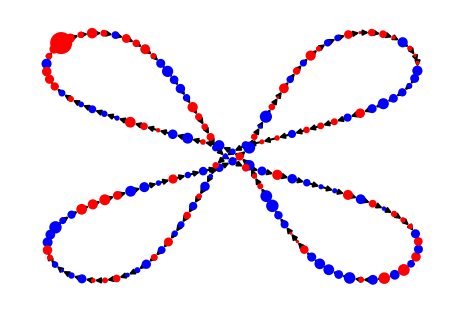

In [8]:
gft_timecourse = np.array([operations.GFT(timecourses[:, t], U=U, Uinv=Uinv) for t in range(T)])
subcycle1_spikes = gft_timecourse[::4]
subcycle2_spikes = gft_timecourse[1::4]
subcycle3_spikes = gft_timecourse[2::4]
subcycle4_spikes = gft_timecourse[3::4]

graph_utils.plot_graph(G, timecourses[:, 1::4][:, 1], pos, scale=10, arrowsize=5)

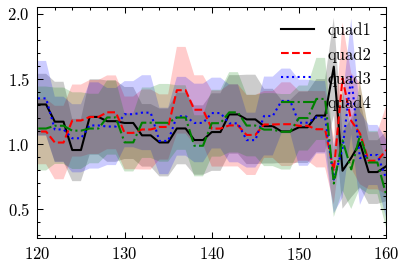

In [9]:
spikes = [subcycle1_spikes, subcycle2_spikes, subcycle3_spikes, subcycle4_spikes]
for k in range(len(spikes)):
    mean = np.abs(spikes[k]).mean(axis=0)
    std = np.abs(spikes[k]).std(axis=0)/2

    plt.plot(np.arange(1, len(mean)+1), mean, label=f'quad{k+1}')
    plt.fill_between(np.arange(1, len(mean)+1), mean - std, mean + std, alpha=0.2)
plt.xlim(120,160)
plt.legend()

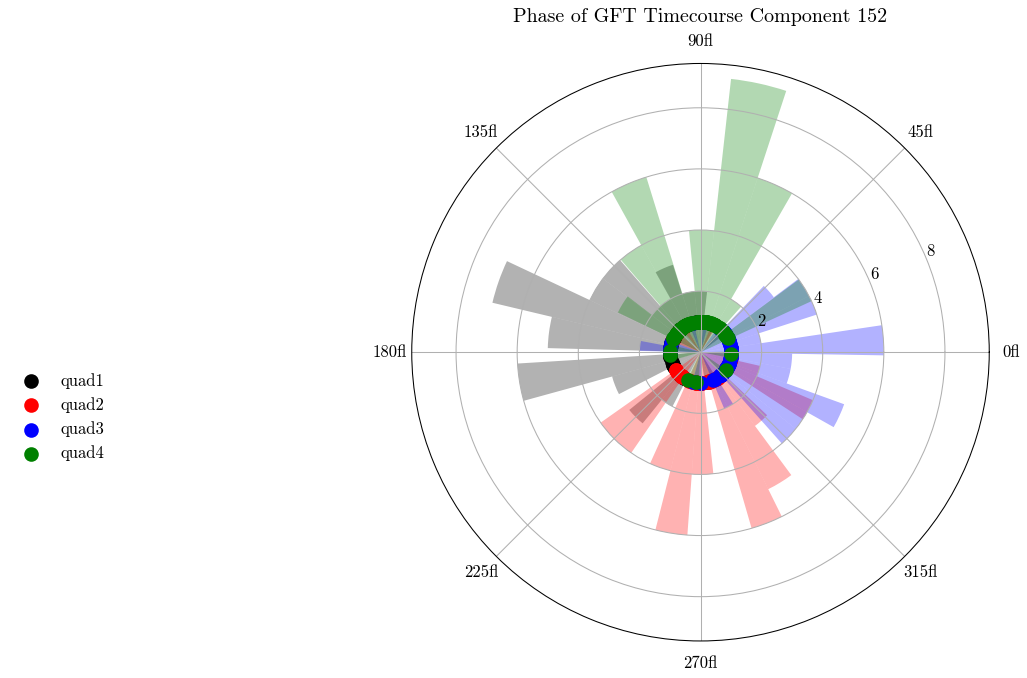

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))

harmo_idx = 151
for k in range(len(spikes)):
    angles = np.angle(spikes[k])[1:, harmo_idx]
    time = np.arange(len(angles))
    sc = ax.scatter(angles, np.ones(len(angles)), alpha=1, label=f'quad{k+1}')
    ax.hist(angles, bins=30, alpha=0.3)
    # plt.colorbar(sc, label='Time')

ax.legend(loc=(-.7,0.3))
ax.set_title(f'Phase of GFT Timecourse Component {harmo_idx+1}')
plt.show()

### Simulated example - Modular blocks

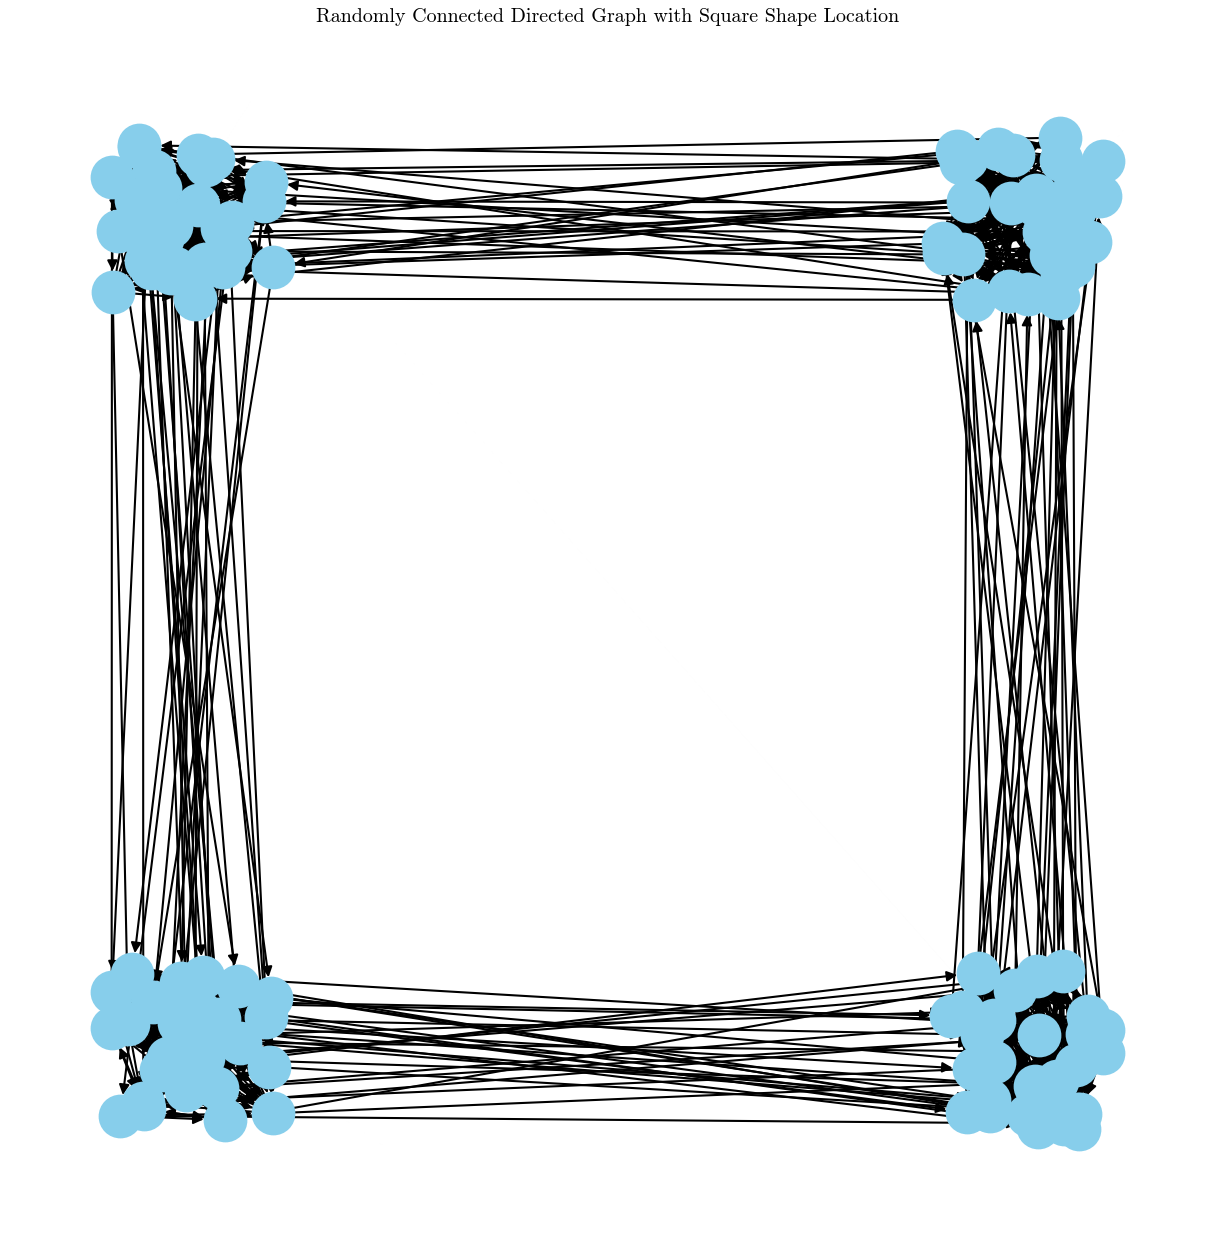

Method chosen is: eig
Method chosen is: eig


In [11]:
nodes_per_block = 30
# Create a directed graph
np.random.seed(0)
# Create random directed graphs for each block
G_random_block1 = nx.gnp_random_graph(nodes_per_block, 0.4, directed=True, seed=1)
G_random_block2 = nx.gnp_random_graph(nodes_per_block, 0.4, directed=True, seed=0)
G_random_block3 = nx.gnp_random_graph(nodes_per_block, 0.4, directed=True, seed=0)
G_random_block4 = nx.gnp_random_graph(nodes_per_block, 0.4, directed=True, seed=0)

# Create a union of these graphs
G_union = nx.disjoint_union_all([G_random_block1, G_random_block2, G_random_block3, G_random_block4])

# Add directed edges between the blocks
for i in range(nodes_per_block):
    G_union.add_edge(i, i + nodes_per_block)  # block1 to block2
    G_union.add_edge(i + nodes_per_block, i + 2 * nodes_per_block)  # block2 to block3
    G_union.add_edge(i + 2 * nodes_per_block, i + 3 * nodes_per_block)  # block3 to block4
    G_union.add_edge(i + 3 * nodes_per_block, i)  # block4 to block1

# Generate random positions in a square shape for each block
pos_square = {}
quadrant = [(0,0), (1,0), (1,1), (0,1)]
for i in range(4):
    r, c = quadrant[i]
    pos_square.update({j + i * nodes_per_block: (np.random.rand() + 5*r, np.random.rand() + 5*c) for j in range(nodes_per_block)})

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(G_union, pos_square, with_labels=False, node_size=400, node_color='skyblue', arrowsize=10)
plt.title("Randomly Connected Directed Graph with Square Shape Location")
plt.show()

A = nx.adjacency_matrix(G_union).toarray()
Au = ((A.T + A)>0).astype(float)

L = operations.compute_directed_laplacian(A)
Lu = operations.compute_directed_laplacian(Au)

U, V = operations.compute_basis(L)
Uu, Vu = operations.compute_basis(Lu)

Uinv = np.linalg.inv(U)
Uinvu = np.linalg.inv(Uu)
N = A.shape[0]
assert np.linalg.cond(U) < 3e2, "U is ill-conditioned"

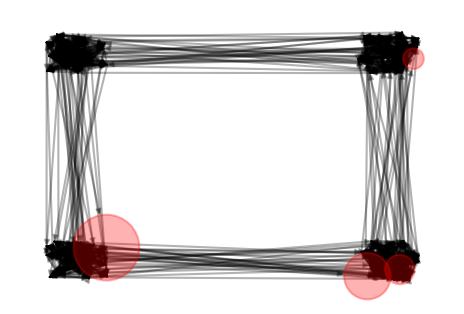

In [12]:
cycle_signal = np.zeros(N)
cycle_signal[10] = 10
cycle_signal[30] = 5
cycle_signal[50] = 2
cycle_signal[70] = 1
graph_utils.plot_graph(G_union, cycle_signal, pos_square, arrowsize=5, alpha=0.3)

Text(0.5, 1.0, 'Imaginary part  #13')

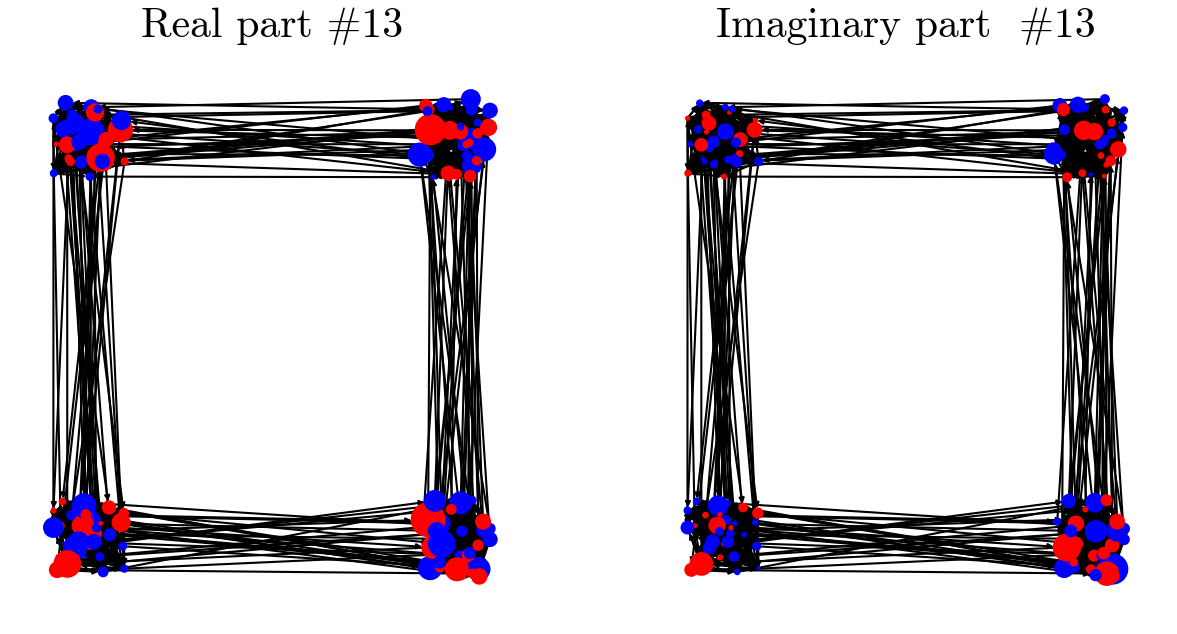

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
harmonic = 13
graph_utils.plot_graph(G_union, U[:, harmonic].real, pos_square, scale=800, arrowsize=5, ax=ax[0])
graph_utils.plot_graph(G_union, U[:, harmonic].imag, pos_square, scale=800, arrowsize=5, ax=ax[1])
ax[0].set_title(f"Real part #{harmonic}", size=20)
ax[1].set_title(f"Imaginary part  #{harmonic}", size=20)

Same active cell

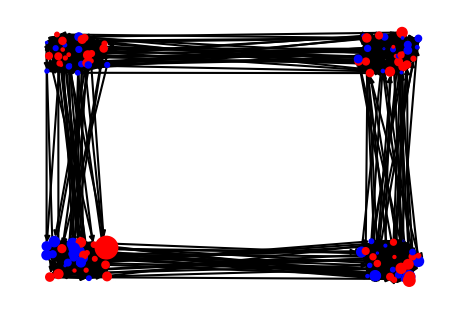

In [16]:
# Seeing same node within cluster light up
T = 400
timecourses = np.zeros((N, T))
excite_amp = 10

wn_sequences = directed_wn_generator(T, U)
# initial condition
timecourses[:, 0] = wn_sequences[0]
block1 = np.zeros(N) ; block1[10] = excite_amp
block2 = np.zeros(N) ; block2[30] = excite_amp
block3 = np.zeros(N) ; block3[50] = excite_amp
block4 = np.zeros(N) ; block4[70] = excite_amp

# Generate timecourses
for t in range(1, T):
    timecourses[:, t] += wn_sequences[t]
    if t > T//4 and t < 2 * T//4:
        timecourses[:, t] += block2
    elif t > 2 * T//4 and t < 3 * T//4:
        timecourses[:, t] += block3
    elif t > 3 * T//4 and t < 4 * T//4:
        timecourses[:, t] += block4
    else:
        timecourses[:, t] += block1

graph_utils.plot_graph(G_union, timecourses[:, 4], pos_square, scale=10, arrowsize=5)

In [17]:
gft_timecourse = np.array([operations.GFT(timecourses[:, t], U=U, Uinv=Uinv) for t in range(T)])
gft_timecourse_undirect = np.array([operations.GFT(timecourses[:, t], U=Uu, Uinv=Uinvu) for t in range(T)])

subblock1_spikes = gft_timecourse[:T//4]
subblock2_spikes = gft_timecourse[T//4:2*T//4]
subblock3_spikes = gft_timecourse[2*T//4:3*T//4]
subblock4_spikes = gft_timecourse[3*T//4:4*T//4]

subblock1_spikes_u = gft_timecourse_undirect[:T//4]
subblock2_spikes_u = gft_timecourse_undirect[T//4:2*T//4]
subblock3_spikes_u = gft_timecourse_undirect[2*T//4:3*T//4]
subblock4_spikes_u = gft_timecourse_undirect[3*T//4:4*T//4]

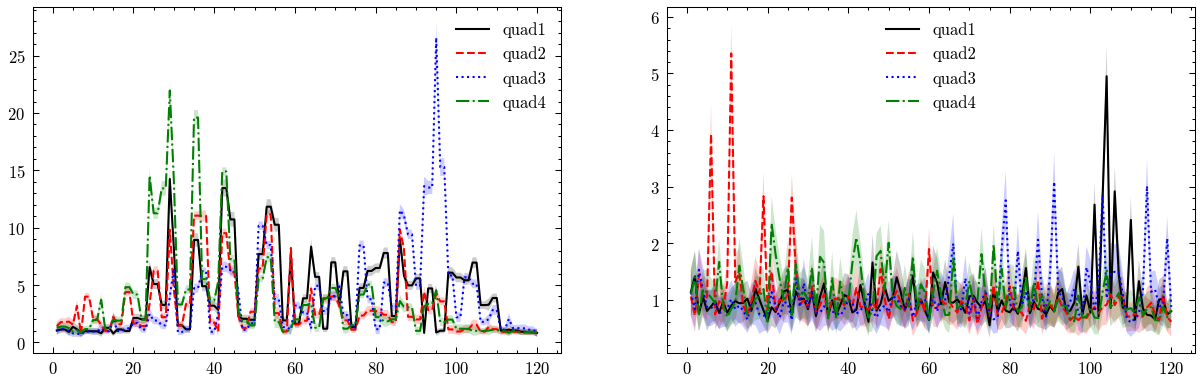

In [18]:
spikes = [subblock1_spikes, subblock2_spikes, subblock3_spikes, subblock4_spikes]
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for k in range(len(spikes)):
    mean = np.abs(spikes[k]).mean(axis=0)
    std = np.abs(spikes[k]).std(axis=0)/2

    ax[0].plot(np.arange(1, len(mean)+1), mean, label=f'quad{k+1}')
    ax[0].fill_between(np.arange(1, len(mean)+1), mean - std, mean + std, alpha=0.2)

ax[0].legend()

spikes_u = [subblock1_spikes_u, subblock2_spikes_u, subblock3_spikes_u, subblock4_spikes_u]
for k in range(len(spikes_u)):
    mean = np.abs(spikes_u[k]).mean(axis=0)
    std = np.abs(spikes_u[k]).std(axis=0)/2

    ax[1].plot(np.arange(1, len(mean)+1), mean, label=f'quad{k+1}')
    ax[1].fill_between(np.arange(1, len(mean)+1), mean - std, mean + std, alpha=0.2)

ax[1].legend()

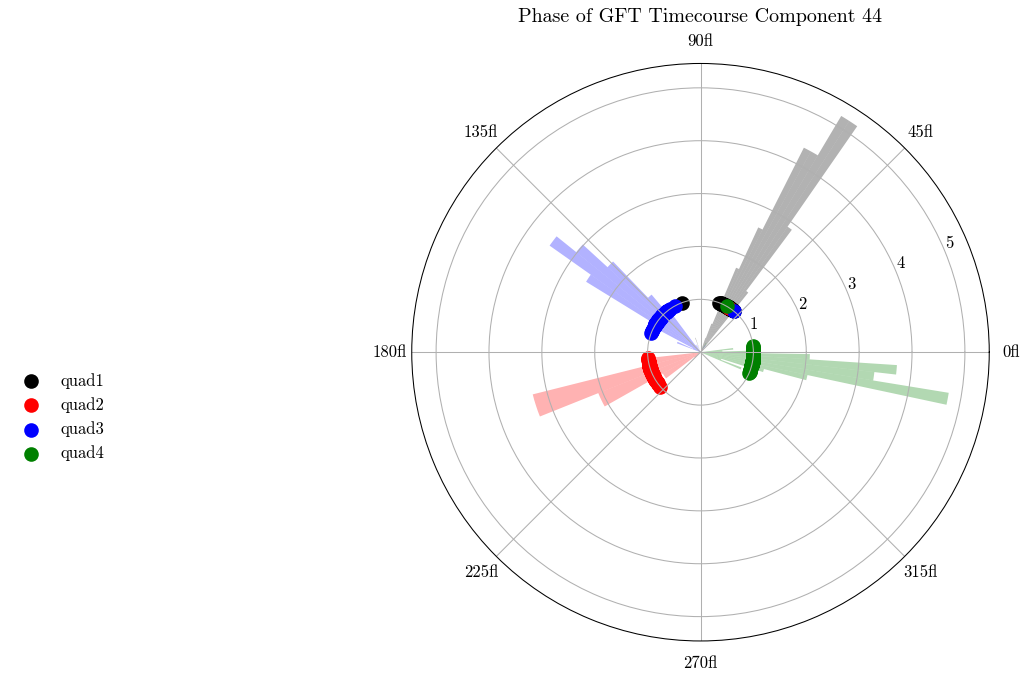

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))

harmo_idx = 43
for k in range(len(spikes)):
    angles = np.angle(spikes[k])[:, harmo_idx]
    time = np.arange(len(angles))
    sc = ax.scatter(angles, np.ones(len(angles)), alpha=1, label=f'quad{k+1}')
    ax.hist(angles, bins=30, alpha=0.3, density=True)
    # plt.colorbar(sc, label='Time')

ax.legend(loc=(-.7,0.3))
ax.set_title(f'Phase of GFT Timecourse Component {harmo_idx+1}')
plt.show()

Block activity with random distribution but amplitude energy strength

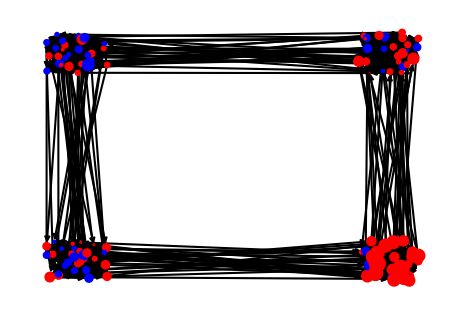

In [31]:
# Seeing same node within cluster light up
T = 400
timecourses = np.zeros((N, T))
excite_amp = 2

wn_sequences = directed_wn_generator(T, U)
# initial condition
timecourses[:, 0] = wn_sequences[0]

block2 = np.zeros(N) ; block2[30] = excite_amp
block3 = np.zeros(N) ; block3[50] = excite_amp
block4 = np.zeros(N) ; block4[70] = excite_amp

np.random.seed(99)
# Generate timecourses
for t in range(1, T):
    timecourses[:, t] += wn_sequences[t]

    if t > T//4 and t < 2 * T//4:
        block = np.zeros(N) ; block[N//4 : 2 * N//4] = np.random.multivariate_normal(np.ones(N//4) * excite_amp, np.eye(N//4)/10, 1)[0]
        timecourses[:, t] += block
    elif t > 2 * T//4 and t < 3 * T//4:
        block = np.zeros(N) ; block[2 * N//4 : 3 * N//4] = np.random.multivariate_normal(np.ones(N//4) * excite_amp, np.eye(N//4)/10, 1)[0]
        timecourses[:, t] += block
    elif t > 3 * T//4 and t < 4 * T//4:
        block = np.zeros(N) ; block[3 * N//4 : 4 * N//4] = np.random.multivariate_normal(np.ones(N//4) * excite_amp, np.eye(N//4)/10, 1)[0]
        timecourses[:, t] += block
    else:
        block = np.zeros(N) ; block[:N//4] = np.random.multivariate_normal(np.ones(N//4) * excite_amp, np.eye(N//4)/10, 1)[0]
        timecourses[:, t] += block

graph_utils.plot_graph(G_union, timecourses[:, 110], pos_square, scale=10, arrowsize=5)

In [21]:
gft_timecourse = np.array([operations.GFT(timecourses[:, t], U=U, Uinv=Uinv) for t in range(T)])
gft_timecourse_undirect = np.array([operations.GFT(timecourses[:, t], U=Uu, Uinv=Uinvu) for t in range(T)])

subblock1_spikes = gft_timecourse[:T//4]
subblock2_spikes = gft_timecourse[T//4:2*T//4]
subblock3_spikes = gft_timecourse[2*T//4:3*T//4]
subblock4_spikes = gft_timecourse[3*T//4:4*T//4]

subblock1_spikes_u = gft_timecourse_undirect[:T//4]
subblock2_spikes_u = gft_timecourse_undirect[T//4:2*T//4]
subblock3_spikes_u = gft_timecourse_undirect[2*T//4:3*T//4]
subblock4_spikes_u = gft_timecourse_undirect[3*T//4:4*T//4]

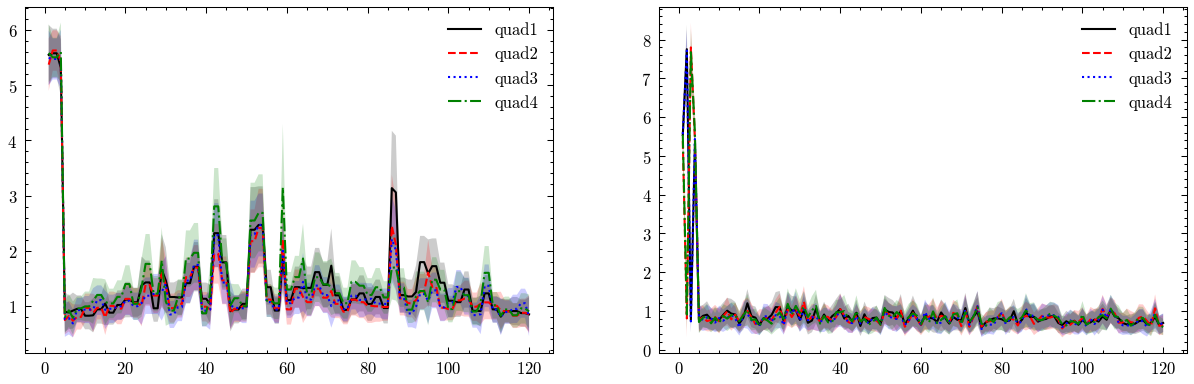

In [25]:
spikes = [subblock1_spikes, subblock2_spikes, subblock3_spikes, subblock4_spikes]
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for k in range(len(spikes)):
    mean = np.abs(spikes[k]).mean(axis=0)
    std = np.abs(spikes[k]).std(axis=0)/2

    ax[0].plot(np.arange(1, len(mean)+1), mean, label=f'quad{k+1}')
    ax[0].fill_between(np.arange(1, len(mean)+1), mean - std, mean + std, alpha=0.2)

ax[0].legend()

spikes_u = [subblock1_spikes_u, subblock2_spikes_u, subblock3_spikes_u, subblock4_spikes_u]
for k in range(len(spikes_u)):
    mean = np.abs(spikes_u[k]).mean(axis=0)
    std = np.abs(spikes_u[k]).std(axis=0)/2

    ax[1].plot(np.arange(1, len(mean)+1), mean, label=f'quad{k+1}')
    ax[1].fill_between(np.arange(1, len(mean)+1), mean - std, mean + std, alpha=0.2)

# ax[0].set_xlim(0,10)
# ax[1].set_xlim(0,10)
ax[1].legend()

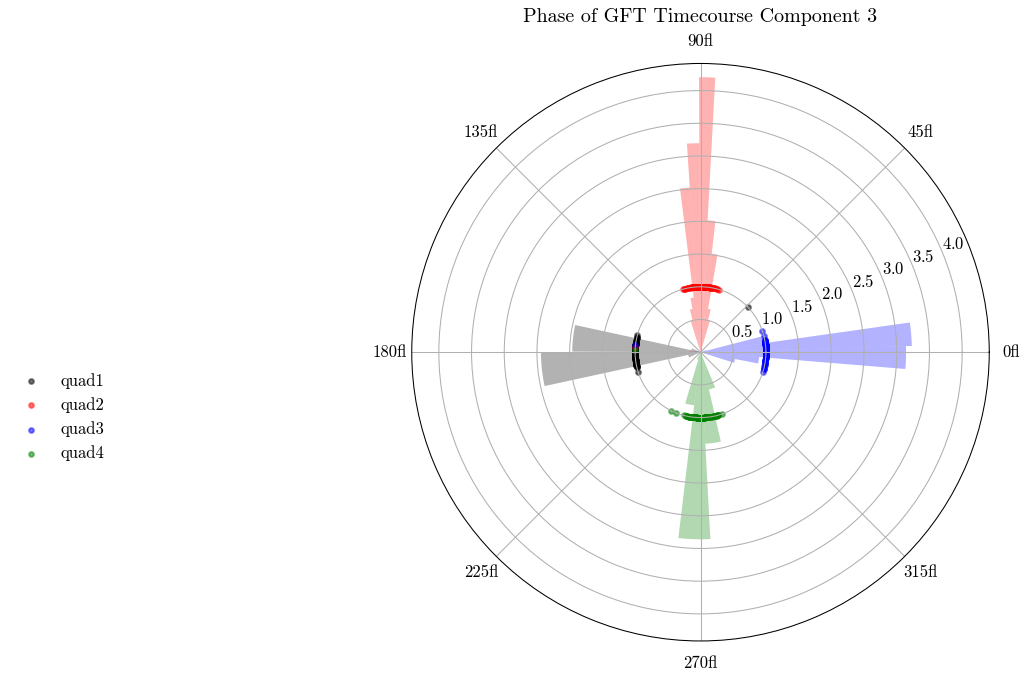

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))

harmo_idx = 2
for k in range(len(spikes)):
    angles = np.angle(spikes[k])[:, harmo_idx]
    time = np.arange(len(angles))
    sc = ax.scatter(angles, np.ones(len(angles)), alpha=0.5, label=f'quad{k+1}', s=5)
    ax.hist(angles, bins=30, alpha=0.3, density=True)
    # plt.colorbar(sc, label='Time')

ax.legend(loc=(-.7,0.3))
ax.set_title(f'Phase of GFT Timecourse Component {harmo_idx+1}')
plt.show()

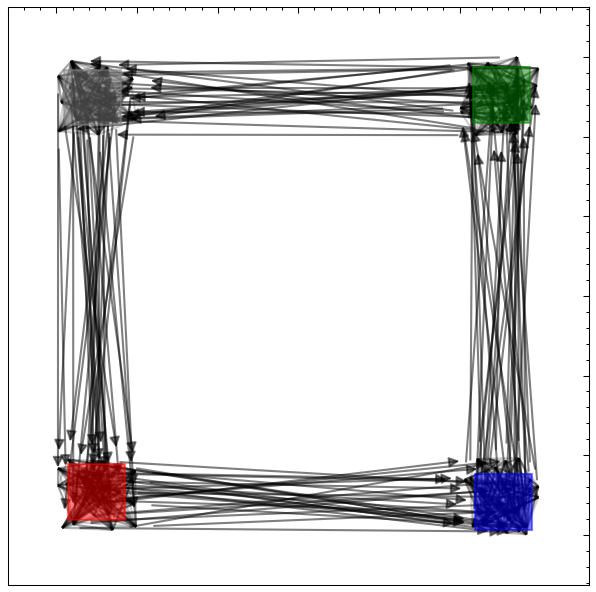

In [65]:
fig, ax = plt.subplots(1, figsize=(5,5))
# Plot the graph without arrows for within blocks
edges_within_blocks = [(u, v) for u, v in G_union.edges() if u // nodes_per_block == v // nodes_per_block]
edges_between_blocks = [(u, v) for u, v in G_union.edges() if u // nodes_per_block != v // nodes_per_block]

# Plot nodes and edges within blocks without arrows
# nx.draw_networkx_nodes(G_union, pos_square, node_size=50, node_color='skyblue', ax=ax)
nx.draw_networkx_edges(G_union, pos_square, edgelist=edges_within_blocks, arrows=False, ax=ax, alpha=0.2)

# Plot edges between blocks with arrows
nx.draw_networkx_edges(G_union, pos_square, edgelist=edges_between_blocks, arrows=True, arrowstyle='-|>', arrowsize=10, ax=ax, alpha=0.5)
colors = ['red', 'blue', 'green', 'gray']
centers = [np.array(list(pos_square.values()))[0:nodes_per_block].mean(axis=0)]
centers.append(np.array(list(pos_square.values()))[nodes_per_block:2*nodes_per_block].mean(axis=0))
centers.append(np.array(list(pos_square.values()))[2*nodes_per_block:3*nodes_per_block].mean(axis=0))
centers.append(np.array(list(pos_square.values()))[3*nodes_per_block:4*nodes_per_block].mean(axis=0))

for center in range(len(centers)):
    x,y = centers[center]
    color = colors[center]
    radius = 0.7
    square = plt.Rectangle((x - radius/2, y - radius/2), radius, radius, color=color, alpha=0.5)
    ax.add_patch(square)